In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '9'

In [89]:
from typing import Callable, Sequence, Tuple

import jax
import jax.numpy as jnp
from jax import random
from flax import linen as nn

from jaxrl.networks.common import MLP, default_init
from jaxrl.networks.common import InfoDict, Model, PRNGKey
from jaxrl.networks import policies


In [3]:
from ensemble_jaxrl.agents.sacn2_tta.sac_learner import SACLearner


Choosing the latest nvidia driver: /usr/lib/nvidia-465, among ['/usr/lib/nvidia-375', '/usr/lib/nvidia-465']
Choosing the latest nvidia driver: /usr/lib/nvidia-465, among ['/usr/lib/nvidia-375', '/usr/lib/nvidia-465']


No module named 'flow'
/home/dibya/miniconda3/envs/contextual/lib/python3.8/site-packages/glfw/__init__.py:906: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
No module named 'carla'
pybullet build time: Dec  1 2021 18:33:43


In [132]:
import ml_collections


def get_config():
    config = ml_collections.ConfigDict()

    config.algo = 'sac'

    config.actor_lr = 3e-4
    config.critic_lr = 3e-4
    config.temp_lr = 3e-4

    config.hidden_dims = (256, 256, 256) # Changed to be 3 layers
    config.n_ensemble = 100

    config.discount = 0.99

    config.tau = 0.005
    config.target_update_period = 1

    config.init_temperature = 1.0
    config.target_entropy = None
    config.backup_entropy = True

    config.replay_buffer_size = None

    return config


In [5]:
from jaxrl.datasets import make_env_and_dataset
import numpy as np

In [133]:
env, dataset = make_env_and_dataset('hopper-random-v2', 0, 'd4rl', None)

/home/dibya/miniconda3/envs/contextual/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
load datafile: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.07it/s]


(999999, 3) float32


In [134]:
agent = SACLearner(0,
                      env.observation_space.sample()[np.newaxis],
                      env.action_space.sample()[np.newaxis], **get_config())

Got extra kwargs:  {'algo': 'sac', 'replay_buffer_size': None}


ic| critic.shape: (100, 1, 1)
ic| critic.shape: (100, 1, 1)


In [141]:
import gzip
import pickle
import os
i = 2900000

def load(agent, fname):
    with gzip.open(fname, "rb") as f:
        state_dict = pickle.load(f)
    agent.load(state_dict)

folder = '../tmp/20220116_testsacn/sacn_100_min_20220116_175402/'
fname = os.path.join(folder, f'iter_{i}.gz')
load(agent, fname)

In [148]:
for i in range(100000, 3000000, 100000):
    fname = os.path.join(folder, f'iter_{i}.gz')
    load(agent, fname)
    episodes, traj = evaluate(agent, env, 10, temperature=1.0)
    print(i, np.mean(episodes['return']))

100000 31.764322113347873
200000 31.426805080014965
300000 8.055269884878236
400000 7.501862310669106
500000 31.376934309163005
600000 8.049098046106444
700000 7.7441220771657076
800000 7.784667825248259
900000 7.599191382682039
1000000 7.855876433026387
1100000 10.15393814905421
1200000 31.22948192853695
1300000 7.986438243099298
1400000 8.31996550696563
1500000 7.028315283673756
1600000 7.309031300794888
1700000 7.602949336868628
1800000 31.313044858029563
1900000 8.29398324674346
2000000 7.804944324019365
2100000 31.314128168685755
2200000 31.389073129277886
2300000 7.714903351249734
2400000 8.066974353514707
2500000 31.259069007363802
2600000 31.30523858286889
2700000 8.598512016479509
2800000 8.807908080888508
2900000 7.663001470013555


In [143]:
agent.tta = False

In [147]:
from typing import Dict

import flax.linen as nn
import gym
import numpy as np
from collections import defaultdict

def evaluate(agent, env: gym.Env, num_episodes: int, temperature=0.0, get_traj=False) -> Dict[str, float]:
    stats = {'return': [], 'length': []}
    stats = defaultdict(list)
    traj = defaultdict(list)
    successes = None
    for _ in range(num_episodes):
        observation, done = env.reset(), False
        while not done:
            action = agent.sample_actions(observation, temperature=temperature)
            new_observation, r, done, info = env.step(action)
            if get_traj:
                traj['observation'].append(observation)
                traj['action'].append(action)
                traj['next_observation'].append(new_observation)
                traj['r'].append(r)
                traj['done'].append(done)
            
            observation = new_observation
        for k in info:
            if isinstance(info[k], dict):
                continue
            stats[k].append(info[k])
        for k in info['episode']:
            stats[k].append(info['episode'][k])
    #     for k, v in stats.items():
    #         stats[k] = np.mean(v)
    return stats, {k: np.stack(v) for k, v in traj.items()}


In [144]:
agent.tta = False
episodes, traj = evaluate(agent, env, 10)

{'total': {'timesteps': 2999}, 'episode': {'return': 7.990828643457841, 'length': 102, 'duration': 0.057926177978515625}}
{'total': {'timesteps': 3100}, 'episode': {'return': 7.956238505157168, 'length': 101, 'duration': 0.04507589340209961}}
{'total': {'timesteps': 3202}, 'episode': {'return': 8.005206993786967, 'length': 102, 'duration': 0.04583597183227539}}
{'total': {'timesteps': 3302}, 'episode': {'return': 7.85150671999458, 'length': 100, 'duration': 0.043992042541503906}}
{'total': {'timesteps': 3404}, 'episode': {'return': 8.009987925482916, 'length': 102, 'duration': 0.04337477684020996}}
{'total': {'timesteps': 3505}, 'episode': {'return': 7.951369532704625, 'length': 101, 'duration': 0.04431653022766113}}
{'total': {'timesteps': 3606}, 'episode': {'return': 7.949291592266289, 'length': 101, 'duration': 0.04461216926574707}}
{'total': {'timesteps': 3707}, 'episode': {'return': 7.944206811200856, 'length': 101, 'duration': 0.04405379295349121}}
{'total': {'timesteps': 3808}, 

In [16]:
episodes

defaultdict(list,
            {'TimeLimit.truncated': 1.0,
             'return': 20.166821666951023,
             'length': 922.3,
             'duration': 0.447719407081604})

In [22]:
@jax.jit
def get_Q(critic, s, a):
    return critic(s, a)

In [150]:
i = 2400000
fname = os.path.join(folder, f'iter_{i}.gz')
load(agent, fname)
episodes, traj = evaluate(agent, env, 10, temperature=1.0, get_traj=True)
print(i, np.mean(episodes['return']))

2400000 8.093111324792932


In [152]:
Q = get_Q(agent.critic, traj['observation'], traj['action'])

ic| critic.shape: (100, 1044, 1)


In [37]:
@jax.jit
def get_target(key, critic, actor, ns, r, done, discount, temp):
    dist = actor(ns)
    next_actions = dist.sample(seed=key)
    next_log_probs = dist.log_prob(next_actions)
    next_q_ensemble = critic(ns, next_actions)
    target_q = r + discount * (1 - done) * next_q_ensemble
    target_q -= discount * (1- done) * temp() * next_log_probs
    return target_q

In [153]:
Q_targets = get_target(agent.rng, agent.critic, agent.actor,
           traj['next_observation'], traj['r'], traj['done'], 0.99, agent.temp)

ic| critic.shape: (100, 1044, 1)


103

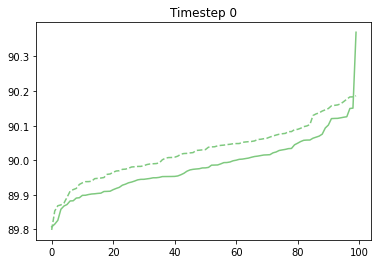

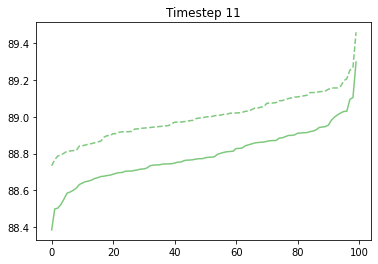

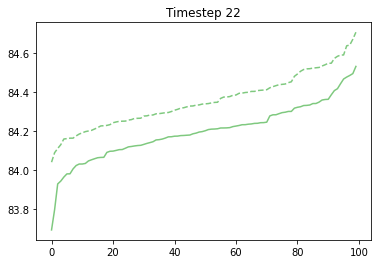

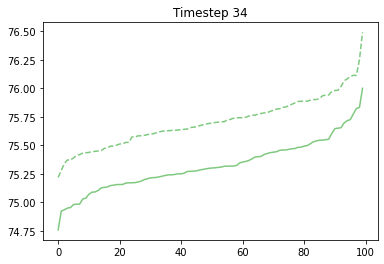

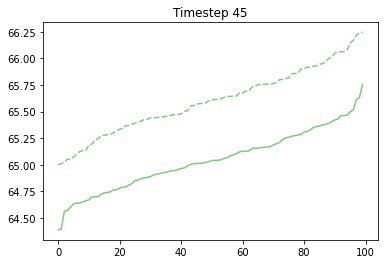

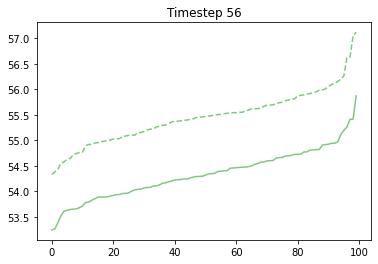

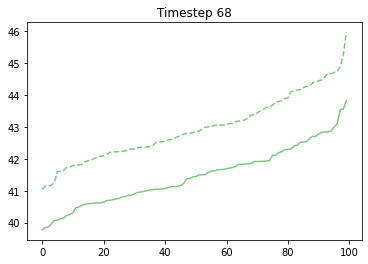

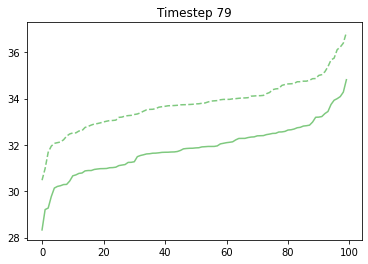

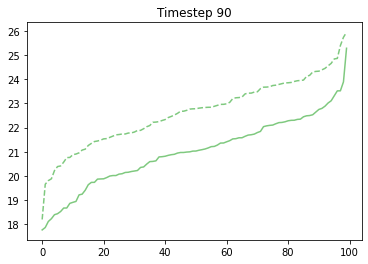

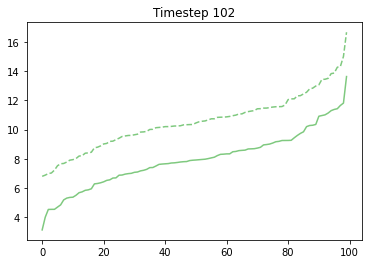

In [160]:
sorted_tQ = jnp.sort(Q_targets, 0)
sorted_Q = jnp.sort(Q, 0)

idxs = np.linspace(0, traj['done'].argmax() - 1, 10).astype(int)
for i in range(10):
    plt.figure()
    plt.plot(sorted_Q[:, idxs[i]], color=plt.cm.Accent(0))
    plt.plot(sorted_tQ[:, idxs[i]], color=plt.cm.Accent(0), linestyle='--')
    plt.title(f'Timestep {idxs[i]}')

In [161]:
import matplotlib.pyplot as plt

In [162]:
from typing import Tuple

import jax
import jax.numpy as jnp

from jaxrl.datasets import Batch
from jaxrl.networks.common import InfoDict, Model, Params, PRNGKey

In [163]:
@jax.jit
def actor_update_order(key: PRNGKey, actor: Model, critic: Model, temp: Model, n: int,
           batch: Batch) -> Tuple[Model, InfoDict]:
    def actor_loss_fn(actor_params: Params) -> Tuple[jnp.ndarray, InfoDict]:
        dist = actor.apply_fn({'params': actor_params}, batch.observations)
        actions = dist.sample(seed=key)
        log_probs = dist.log_prob(actions)
        q_ensemble = critic(batch.observations, actions)
        q = jnp.sort(q_ensemble, 0)[n]
        actor_loss = (log_probs * temp() - q).mean()
        return actor_loss, {
            'actor_loss': actor_loss,
            'entropy': -log_probs.mean()
        }

    new_actor, info = actor.apply_gradient(actor_loss_fn)

    return new_actor, info

In [166]:
all_actors = [agent.actor] * 10

In [167]:
import tqdm
for N in range(5):
    rolling_info = defaultdict(list)
    for i in tqdm.trange(1000):
        all_actors[N], info = actor_update_order(agent.rng, all_actors[N], agent.critic,
                                                agent.temp, 5 * N, dataset.sample(256))
        for k in info:
            rolling_info[k].append(info[k])
        if i % 500 == 0:
            print(N, {k: np.mean(v) for k, v in rolling_info.items()})

  0%|▎                                                                                                                                                       | 2/1000 [00:00<01:47,  9.30it/s]

0 {'actor_loss': -72.957, 'entropy': -1.4422284}


 50%|███████████████████████████████████████████████████████████████████████████▎                                                                          | 502/1000 [00:55<00:52,  9.41it/s]

0 {'actor_loss': -73.16777, 'entropy': -1.5298578}


  0%|▎                                                                                                                                                       | 2/1000 [00:00<01:46,  9.39it/s]

1 {'actor_loss': -74.86708, 'entropy': -1.7497482}


 50%|███████████████████████████████████████████████████████████████████████████▎                                                                          | 502/1000 [00:55<00:54,  9.10it/s]

1 {'actor_loss': -73.51815, 'entropy': -1.5641114}


  0%|▎                                                                                                                                                       | 2/1000 [00:00<01:42,  9.76it/s]

2 {'actor_loss': -75.26906, 'entropy': -1.3766239}


 50%|███████████████████████████████████████████████████████████████████████████▎                                                                          | 502/1000 [00:54<00:53,  9.25it/s]

2 {'actor_loss': -73.59912, 'entropy': -1.6132101}


  0%|▎                                                                                                                                                       | 2/1000 [00:00<01:51,  8.92it/s]

3 {'actor_loss': -72.05511, 'entropy': -1.8155332}


 50%|███████████████████████████████████████████████████████████████████████████▎                                                                          | 502/1000 [00:55<01:00,  8.18it/s]

3 {'actor_loss': -73.69089, 'entropy': -1.6285931}


  0%|▎                                                                                                                                                       | 2/1000 [00:00<01:59,  8.37it/s]

4 {'actor_loss': -75.2265, 'entropy': -1.5092449}


 50%|███████████████████████████████████████████████████████████████████████████▎                                                                          | 502/1000 [00:56<00:56,  8.84it/s]

4 {'actor_loss': -73.85721, 'entropy': -1.6607754}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:50<00:00,  9.04it/s]


In [168]:
from dataclasses import dataclass

class Policy:
    def __init__(self, actor):
        self.actor = actor
        self.rng = jax.random.PRNGKey(0)
        
    def sample_actions(self,
                           observations: np.ndarray,
                           temperature: float = 1.0) -> jnp.ndarray:
        key, self.rng = jax.random.split(self.rng)
        rng, actions = policies.sample_actions(self.rng, self.actor.apply_fn,
                                               self.actor.params, observations,
                                               temperature)
        self.rng = rng

        actions = np.asarray(actions)
        return np.clip(actions, -1, 1)

In [169]:
episodes, traj = evaluate(agent, env, 20)

In [170]:
import seaborn as sns

<AxesSubplot:ylabel='Density'>

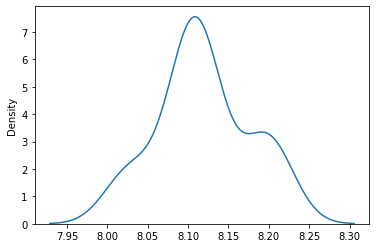

In [171]:
sns.kdeplot(episodes['return'])

In [178]:
all_eps = []
for i in range(5):
    ep, _ = evaluate(Policy(all_actors[i]), env, 20, temperature=1.0)
    all_eps.append(ep)

In [179]:
[(n, np.mean(np.array(ep['return'])), bootstrap_std(np.array(ep['return']))) for n, ep in enumerate(all_eps)]

[(0, 8.23191527797211, 0.022597492517411666),
 (1, 7.877136149429352, 0.018299324590346104),
 (2, 8.52493462734526, 0.01538530205113471),
 (3, 7.995592097150177, 0.015239514242833737),
 (4, 8.592724876831209, 0.023052088113210967)]

In [97]:
import pandas as pd

In [98]:
dfs = []
for n, ep in enumerate(all_eps):
    df = pd.DataFrame.from_dict(dict(ret=ep['return']))
    df['name'] = n
    dfs.append(df)

In [105]:
df = pd.concat(dfs, ignore_index=True)
df

ret  name
0    21.985371     0
1    21.946175     0
2    22.024134     0
3    22.037589     0
4    21.944351     0
..         ...   ...
195  22.027000     9
196  21.964984     9
197  21.954796     9
198  21.932502     9
199  21.956558     9

[200 rows x 2 columns]

ValueError: x and y must have same first dimension, but have shapes (0,) and (200,)

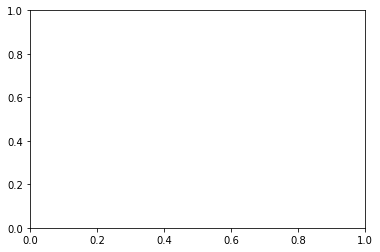

In [124]:
for i in range(10):
    plt.plot( np.sort(-1 * all_eps[i]['return']), np.linspace(0, 1, 200), label=f'{i}')
plt.legend()

In [131]:
[(n, np.mean(np.array(ep['return']) < 20), bootstrap_std(np.array(ep['return']) < 20)) for n, ep in enumerate(all_eps)]

[(0, 0.06, 0.019293061504650377),
 (1, 0.07, 0.01556705923844749),
 (2, 0.01, 0.006324555320336759),
 (3, 0.01, 0.006574360974438672),
 (4, 0.015, 0.008858454843945542),
 (5, 0.04, 0.013631051153728225),
 (6, 0.005, 0.004988876515698589),
 (7, 0.005, 0.0045460605656619515),
 (8, 0.015, 0.009797958971132713),
 (9, 0.03, 0.009889669132764532)]

In [122]:

def bootstrap_std(arr, f=np.mean, n=30):
    arr = np.array(arr)
    return np.std([
        f(arr[np.random.choice(len(arr), len(arr))])
        for _ in range(n)
    ])

In [ ]:
boots